Human in the loop

In [1]:
import os
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001F3F7F6EE70>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001F3F8078F20>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool # custom tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages # reducers
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt # forcefully interrupting so human can provide feedback

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)



In [17]:
@tool
def human_assistance(query: str) -> str:
    """requst assistance from a human"""
    human_response = interrupt({"query": query})
    return human_response["data"]




In [18]:
tool = TavilySearchResults(max_results=2)

tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # we will be interrupting during tool execution
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume

    return {"messages": [message]}

graph_builder.add_node("Chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "Chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "Chatbot")
graph_builder.add_edge(START, "Chatbot")



C:\Users\DELL\AppData\Local\Temp\ipykernel_5920\1894487024.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)
Adding a node to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Node `Chatbot` already present.

In [19]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

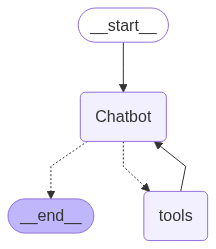

In [20]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [21]:
user_input = "I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": user_input},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()
 

================================ Human Message =================================

I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (r285ndtnt)
 Call ID: r285ndtnt
  Args:
    query: Expert guidance and assistance for building an AI agent
================================= Tool Message =================================
Name: human_assistance

Error: NameError("name 'interrrupt' is not defined")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  human_assistance (07p52zypb)
 Call ID: 07p52zypb
  Args:
    query: I need some expert guidance and assistance for building an AI agent. Could you request assistance for me?
================================= Tool Message =================================
Name: human_assistance

Error: NameError("name 'interrrupt